In [57]:

# Today we are going to build a model to predict the genre of a song from its lyrics
# Program Overview (Some tasks you will have to implement yourself):
# 1. The top songs from various billboard genre charts are downloaded
# 2. The lyrics of each song are downloaded from music mix via their python API
# 3. Raw lyric data and various other billboard variables are saved out to file (so you don't have to download every time!)
# 4. Song lyrics are converted to vectors of word counts via sklearn
# 6. YOUR TASK 1: Deal with missingness: there are some nans in the data, you'll have to get these out!
# 7. YOUR TASK 2: Convert genre labels to ints
# 8. Train/Test Split
# 9. YOUR TASK 3: Scale X Data (i.e. standardize between -1 and 1)
# 10. Train multiclass logistic regression model to predict genre
# 11. Print accuracy on train/test set

#Think about what the accuracy means...

# 12. EXTRA TASK FOR EXPERTS: Modify steps 9-11 to do k-fold cross-validation with 5 folds
# - This is where you split the data into 5 parts, and train on 4 parts, then test on one. 
#   Then you reorder, so that the train and test sets are made up of different parts, so that each part is tested on at least once

## If you are going to download data then you must download some tools.
# In the command line/terminal paste the following two lines to install the required python packages:
# cd python-client
# python setup.py install
# pip install -r requirements.txt


##Imports##
__author__ = 'bdyetton'
import billboard
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swagger_client
import sklearn
from swagger_client.rest import ApiException
from sklearn.model_selection import train_test_split
import warnings


#import os
#import time
#import csv
#from pprint import pprint
#import urllib3
#urllib3.disable_warnings()
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
## a "pure function", a function that does not rely on anything internal in the download lyrics class, so written seperatly
def get_every_week_since(year, month=1, day=1):
    time_start = datetime.datetime(year=year, month=month, day=day)
    time_inc = datetime.timedelta(days=7)
    time_now = datetime.datetime.now()
    current_time = time_start
    times = []
    while current_time < time_now:
        times.append(current_time)
        current_time += time_inc
    return len(times), times

In [58]:
## Class def
class DownloadSongsAndLyrics(object):
    """A quick and dirty program to download the top billboard songs from a range of genre's and then grab their lyrics from musicmix"""

    def __init__(self):
        swagger_client.configuration.api_key['apikey'] = '82414131af109a5fbece76fd5bff52bb'
        self.musicmix_lyric_instance = swagger_client.LyricsApi()
        self.musicmix_track_instance = swagger_client.TrackApi()


    def get_all_songs_from_all_charts(self,songs_per_week=1,get_all_years_since=2017,charts=['hot-holiday-songs','christian-songs','country-songs','rock-songs','pop-songs','r-b-hip-hop-songs','dance-electronic-songs']):
        """Downloads all the song indormation (w.o. lyrics) from all billboard charts."""
        self.charts = charts
        self.songs_per_week = songs_per_week
        chart_songs = []
        for chart in self.charts:
            chart_songs.append(self.get_all_songs_from_chart(chart,get_all_years_since))
        all_charts_df = pd.concat(chart_songs) #concatinate the list of pandas df to a single df
        return all_charts_df
 
    def get_all_songs_from_chart(self,chart_name,query_year=2017,max_weeks_missing=5):
        print('Beginning download for chart',chart_name)
        num_weeks_to_look_back, weeks_to_look_back = get_every_week_since(year=query_year)
        num_songs_to_download = num_weeks_to_look_back*self.songs_per_week
        #This is where we will save our downloaded song data too
        song_df = pd.DataFrame(columns=('chart','title', 'artist', 'weeks', 'rank', 'query_week', 'lyrics'))
        miss_counter = 0
        #Now step back for num_weeks
        for week_idx in range(0, num_weeks_to_look_back): #Better would be to interate over weeks
            try:
                if week_idx == 0:
                    chart_data = billboard.ChartData(chart_name)
                    next_date_to_get = chart_data.previousDate
                else:             
                    chart_data = billboard.ChartData(chart_name, next_date_to_get)
                    if not chart_data:
                        raise AttributeError("Missing data")
                    else:
                        next_date_to_get = chart_data.previousDate
            except AttributeError as e:
                miss_counter += 1
                if miss_counter > max_weeks_missing:
                    warnings.warn("Too many weeks of this chart missing, moving on to next chart")
                    break
                print("\nMissing song data for %s, %s\n" % (chart_name, next_date_to_get))
                current_missing_date = datetime.datetime.strptime(next_date_to_get, '%Y-%m-%d')
                previous_date = current_missing_date - datetime.timedelta(days=7)
                next_date_to_get = previous_date.strftime('%Y-%m-%d')
                print('trying new date of:',next_date_to_get)
                continue
            songs_from_current_week = 0;
            for song in chart_data:
                if song.title in song_df["title"].values and song.artist in song_df["artist"].values:
                    continue               
                lyrics = self.get_lyric_data_for_song(song.title,song.artist)
                if lyrics is not None:
                    print("\r",'Downloaded song',song_df.shape[0]+1,'of',num_songs_to_download, end="")
                    song_df.loc[song_df.shape[0]+1] = [chart_name,song.title, song.artist, song.weeks, song.rank, chart_data.previousDate,lyrics]
                    songs_from_current_week += 1;
                    if songs_from_current_week >= self.songs_per_week:
                        break
        print(' --- Chart Download Complete')
        return song_df
    
    def get_lyric_data_for_song(self,song_title, song_artist):
        try:
            lyric_response_data = self.musicmix_lyric_instance.matcher_lyrics_get_get(q_track=song_title, q_artist=song_artist)
            lyric_data = lyric_response_data.message.body.lyrics
            if lyric_data is None:
                return None
            return lyric_data.lyrics_body.replace('******* This Lyrics is NOT for Commercial use *******','')
        except ApiException as e:
            print("Warning: Exception when getting lyrics for %s, %s: %s\n" % (e, song.title, song.artist))
            return None    
    
        

In [60]:
## Grab lyrics: use the above function
downloader = DownloadSongsAndLyrics()
all_charts = downloader.get_all_songs_from_all_charts(songs_per_week=5,get_all_years_since=2016)
all_charts.to_csv('BillboardLyricData.txt', sep='\t', encoding='utf-8') #write that bad boy out to file

Beginning download for chart hot-holiday-songs
 Downloaded song 50 of 34525 of 345Downloaded song 33 of 345Downloaded song 38 of 345
Missing song data for hot-holiday-songs, 2015-12-05

trying new date of: 2015-11-28

Missing song data for hot-holiday-songs, 2015-11-28

trying new date of: 2015-11-21

Missing song data for hot-holiday-songs, 2015-11-21

trying new date of: 2015-11-14

Missing song data for hot-holiday-songs, 2015-11-14

trying new date of: 2015-11-07

Missing song data for hot-holiday-songs, 2015-11-07

trying new date of: 2015-10-31


C:\Users\bdyet\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: UserWarning: Too many weeks of this chart missing, moving on to next chart


 --- Chart Download Complete
Beginning download for chart christian-songs
 Downloaded song 269 of 345 --- Chart Download Complete
Beginning download for chart country-songs
 Downloaded song 244 of 345 --- Chart Download Complete
Beginning download for chart rock-songs
 Downloaded song 343 of 345 --- Chart Download Complete 345 242 of 345Downloaded song 253 of 345
Beginning download for chart pop-songs
 Downloaded song 222 of 345 --- Chart Download Completeaded song 10 of 345Downloaded song 18 of 345 91 of 345of 345
Beginning download for chart r-b-hip-hop-songs
 Downloaded song 323 of 345 --- Chart Download Completeloaded song 68 of 345 124 of 345 182 of 345Downloaded song 223 of 345
Beginning download for chart dance-electronic-songs
 Downloaded song 293 of 345ownloaded song 20 of 345120 of 345 175 of 345 --- Chart Download Complete


In [61]:
class MultiClassLogisticRegressorPurePython(object):
    
    def __init__(self, lr, n_iter):
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.m_ = X.shape[0]
        self.w_ = np.zeros((X.shape[1], self.n_classes_))
        self.cost_ = []
        
        
        for i in range(self.n_iter):
            z = self.net_input(X)
            assert not np.isnan(np.sum(z))
            p_y = self.softmax_fn(z)
            y_onehot = self.onehot_fn(y)
            error = (y_onehot - p_y)
            grad =  (-1 / self.m_) * X.T.dot(error) 
            self.w_ = self.w_ - (self.lr * grad)
                
        
            cost = (-1 / self.m_) * np.sum(y_onehot * np.log(p_y))
            self.cost_.append(cost)
            
        return self
    
    def onehot_fn(self, y):
        onehot = np.eye(self.n_classes_)[y]
        return onehot

    def net_input(self, X):
        return np.dot(X, self.w_)

    def predict(self, X):
        z = self.net_input(X)
        return np.argmax(self.softmax_fn(z), axis=1)
    
    def softmax_fn(self, z):
        z -= np.max(z)
        softmax = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
        return softmax

In [62]:
#If you are not downloading data, then start here
all_charts = pd.read_csv('BillboardLyricData.txt', sep='\t', encoding='utf-8')
print('Raw DataFrame size:',all_charts.shape)

Raw DataFrame size: (1744, 8)


In [63]:
## YOUR TASK 1: Remove missing data (hint: page 101, in Raschka)   
all_charts = all_charts.dropna()
#all_charts = #YOU WRITE SOMETHING HERE
print('Raw DataFrame size after missing data removed:',all_charts.shape)

Raw DataFrame size after missing data removed: (1710, 8)


In [77]:
# Song lyrics are converted to vectors of word counts via sklearn
n_features_to_extract_from_text = 500 #Number of predictor variables (words to use as predictors)
vectorizer = CountVectorizer(max_df=0.95, min_df=2,max_features=n_features_to_extract_from_text,stop_words='english')                              
vectorizer.fit(all_charts.lyrics) #Creates the dictionary to convert lyrics to counts
word_vector = vectorizer.transform(all_charts.lyrics) #Does actual conversion
X = word_vector.todense()
print('X data (word count features) size',X.shape)

X data (word count features) size (1710, 500)


In [78]:
# 7. YOUR TASK 2: Convert genre lables to ints
class_mapping = {label:idx for idx,label in enumerate(np.unique(all_charts.chart))}
y = all_charts.chart.map(class_mapping)
#y = #YOU WRITE SOMETHING HERE

In [79]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [80]:
# YOUR TASK 4: Scale X Data (i.e. standardize between -1 and 1): See Raschka
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)
#X_train_std = #YOU WRITE SOMETHING HERE
#X_test_std = #YOU WRITE SOMETHING HERE

C:\Users\bdyet\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


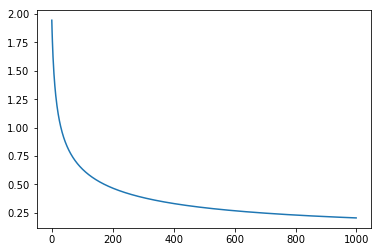

In [81]:
# instantiate and fit model
model_1 = MultiClassLogisticRegressorPurePython(n_iter=1000, lr=0.1)
model_1.fit(X_train_std, y_train)
plt.plot(model_1.cost_)
plt.show()

In [82]:
# evaluate model
print(model_1.predict(X_train_std))
train_acc = np.sum(model_1.predict(X_train_std) == y_train) / float(len(X_train))
test_acc = np.sum(model_1.predict(X_test_std) == y_test) / float(len(X_test))
print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

[6 5 0 ..., 6 1 5]
Train accuracy: 0.9406850459482038
Test accuracy: 0.3645224171539961
